In [1]:
import os
os.chdir('../') #if we are in notebooks folder

In [2]:
import flax
from flax import linen as nn
from flax.core import unfreeze

import jax
import jax.numpy as jnp
import optax

import matplotlib.pyplot as plt
import seaborn as sns

from datasets import cos_normal_noise


from models import mc_dropout
from utils import fit

## Load Dataset

In [3]:
dataset, targets = cos_normal_noise.load()
X, x_test1, x_test2 = dataset
y, y_test1, y_test2 = targets

# MC Dropout

In [4]:
# load the model
model = mc_dropout.load(features=[1, 32, 64, 1])

In [5]:
# initialize model
batch = jax.random.normal(key = jax.random.PRNGKey(0), shape=X.shape)
params = model.init(jax.random.PRNGKey(1), batch, True)

In [6]:
jax.tree_map(jnp.shape, unfreeze(params))

{'params': {'layer0': {'bias': (1,), 'kernel': (1, 1)},
  'layer1': {'bias': (32,), 'kernel': (1, 32)},
  'layer2': {'bias': (64,), 'kernel': (32, 64)},
  'layer3': {'bias': (1,), 'kernel': (64, 1)}}}

In [7]:
params, losses =  fit(model, params, X, y, learning_rate=0.01, epochs=100, verbose=True)

Loss step 0:  0.07013654
Loss step 30:  0.03873171
Loss step 60:  0.03484328
Loss step 90:  0.030987248
Loss step 120:  0.030092828
Loss step 150:  0.02619307
Loss step 180:  0.02548842
Loss step 210:  0.024146976
Loss step 240:  0.02028974
Loss step 270:  0.020142155


Text(0, 0.5, 'y')

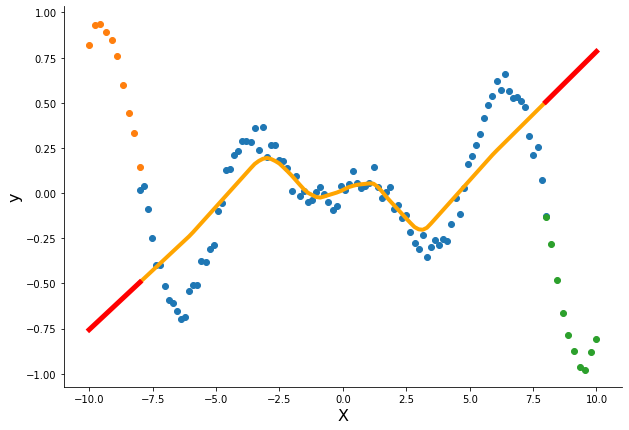

In [8]:
plt.figure(figsize=(10,7))
plt.scatter(X,y)
plt.scatter(x_test1,y_test1)
plt.scatter(x_test2,y_test2)
plt.plot(X, model.apply(params, X, True), "orange", linewidth=4)
plt.plot(x_test1, model.apply(params,x_test1, True),"red", linewidth = 5)
plt.plot(x_test2, model.apply(params,x_test2, True), "red", linewidth = 5)
sns.despine()
plt.xlabel("X",fontsize=16)
plt.ylabel("y",fontsize=16)

In [9]:
x = jnp.linspace(-10, 10, 200).reshape(-1,1)
n_stacks = 100
y_stacks = []
for i in range(n_stacks):
    y_stacks.append(model.apply(params, x, False, rate = 0.1, rngs={"dropout": jax.random.PRNGKey(i)}))

In [10]:
y_stacks = jnp.array(y_stacks)

(-10.0, 10.0)

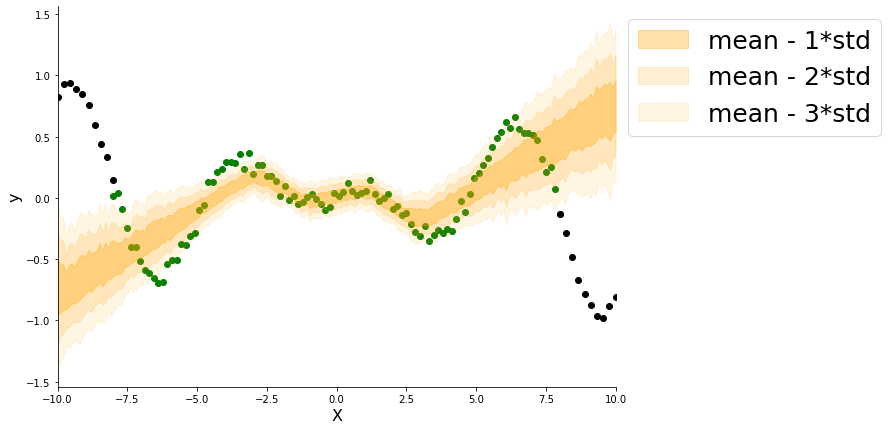

In [11]:
plt.figure(figsize=(10,7))
plt.scatter(X, y, c="g")
plt.scatter(x_test1,y_test1, c="k")
plt.scatter(x_test2,y_test2, c="k")
mean = (y_stacks.mean(axis=0)).squeeze()
std = (y_stacks.std(axis=0)).squeeze()
for i in range(1,4):
    plt.fill_between(x.squeeze(), mean - i*std, mean + i*std, color="orange", alpha = 1/(i*3), label = f"mean - {i}*std")
plt.legend(bbox_to_anchor=(1,1), fontsize=25)
sns.despine()
plt.xlabel("X",fontsize=16)
plt.ylabel("y",fontsize=16)
plt.xlim(-10,10)
# plt.savefig("mc_dropout_.pdf",bbox_inches="tight")